# Data Exploration and Preprocessing

In this notebook, we will load our datasets, explore them, and preprocess them for the unsupervised and supervised learning tasks of the Arvato/Bertelsmann project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import itertools
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
# Setting some options for the print methods in pandas
pd.set_option('max_rows', 400)  # pandas will print at most 400 rows
pd.set_option('max_columns', 400)  # pandas will print at most 400 columns
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppressing scientific notation in pandas prints

# 1. Data loading

In [60]:
%%time
# Load in the data
azdias = pd.read_csv('./data/Udacity_AZDIAS_052018.csv', low_memory=False)
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', low_memory=False)
mailout_train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', low_memory=False)
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', low_memory=False)

Wall time: 57.8 s


**Documentation files**

Two Excel files including some variable documentation were included:
* "DIAS Attributes - Values 2017.xlsx" has information regarding how most of the columns are encoded (similar to a survey item documentation).
* "DIAS Information Levels - Attributes 2017.xlsx" presents information on the observation level of most of the columns, as well as a brief description of the variable meanings.

In [4]:
# Reading in the data dictionary excel files without the empty columns
azdias_values = pd.read_excel('./data/DIAS Attributes - Values 2017.xlsx', header=1, usecols=lambda x: 'Unnamed' not in x)
azdias_info = pd.read_excel('./data/DIAS Information Levels - Attributes 2017.xlsx', header=1, usecols=lambda x: 'Unnamed' not in x)

In [5]:
# Since the excel files were created with a merged cell value for the first 2 columns,
#  let's use the forward-fill strategy to deal with NAs
azdias_values.loc[:, ['Attribute', 'Description']] = azdias_values.loc[:, ['Attribute', 'Description']].ffill().copy()
azdias_info.loc[:, ['Information level']] = azdias_info.loc[:, ['Information level']].ffill().copy()

# 2. Dataset description

Privacy considerations: this data set is not available under a public license. Therefore, the raw data, as well as the full documentation will not be posted.

In [6]:
# Printing the shapes of the four datasets we are using
print('Azdias: {}'.format(azdias.shape))
print('Customers: {}'.format(customers.shape))
print('Customer identification for training: {}'.format(mailout_train.shape))
print('Customer identification for Kaggle predictions: {}'.format(mailout_test.shape))

Azdias: (891221, 366)
Customers: (191652, 369)
Customer identification for training: (42962, 367)
Customer identification for Kaggle predictions: (42833, 366)


In [7]:
# Are there any person overlaps between the four datasets?
print("Customers: minimum LNR ID {}; maximum LNR ID {}".format(customers.LNR.min(), customers.LNR.max()))
print("Azdias: minimum LNR ID {}; maximum LNR ID {}".format(azdias.LNR.min(), azdias.LNR.max()))
print("Mail-out train: minimum LNR ID {}; maximum LNR ID {}".format(mailout_train.LNR.min(), mailout_train.LNR.max()))
print("Mail-out test: minimum LNR ID {}; maximum LNR ID {}".format(mailout_test.LNR.min(), mailout_test.LNR.max()))

Customers: minimum LNR ID 1; maximum LNR ID 191652
Azdias: minimum LNR ID 191653; maximum LNR ID 1082873
Mail-out train: minimum LNR ID 1; maximum LNR ID 85795
Mail-out test: minimum LNR ID 2; maximum LNR ID 85794


 > **There seems to be no overlap between the Azdias and the customers datasets. However, the mailout datasets seem to overlap with the customers dataset.**

## 2.1. Observation Levels: Spearman Rank Cross-Correlations

In [8]:
azdias_info['Information level'].value_counts()

PLZ8                  114
Microcell (RR3_ID)     55
Person                 42
125m x 125m Grid       33
Household              32
Microcell (RR4_ID)     12
Building               10
Community               5
RR1_ID                  5
Postcode                4
Name: Information level, dtype: int64

In the charts below, each dot represents the Spearman rank correlation for each pair of features. The redder the dot, the closer the correlation is to 1. The bluer the dot, the closer the correlation is to -1. A rank correlation equal to 0 is represented as a white dot.

In [64]:
def observation_level_correlations(df, doc_df, observation_level, figure_size, title):
    cols = set(doc_df.loc[doc_df['Information level'] == observation_level, 'Attribute']).intersection(df.columns)
    if len(cols) == 0:
        return 'No features found in the data.'
        
    corr = df[cols].rank().corr(method="pearson")
    
    plt.figure(figsize=figure_size)
    sns.heatmap(corr,
                xticklabels = corr.columns.values,
                yticklabels = corr.columns.values,
                cmap='RdBu_r',
                vmin=-1,
                vmax=1
               )
    plt.title(title)
    plt.show()

### Observation level: person

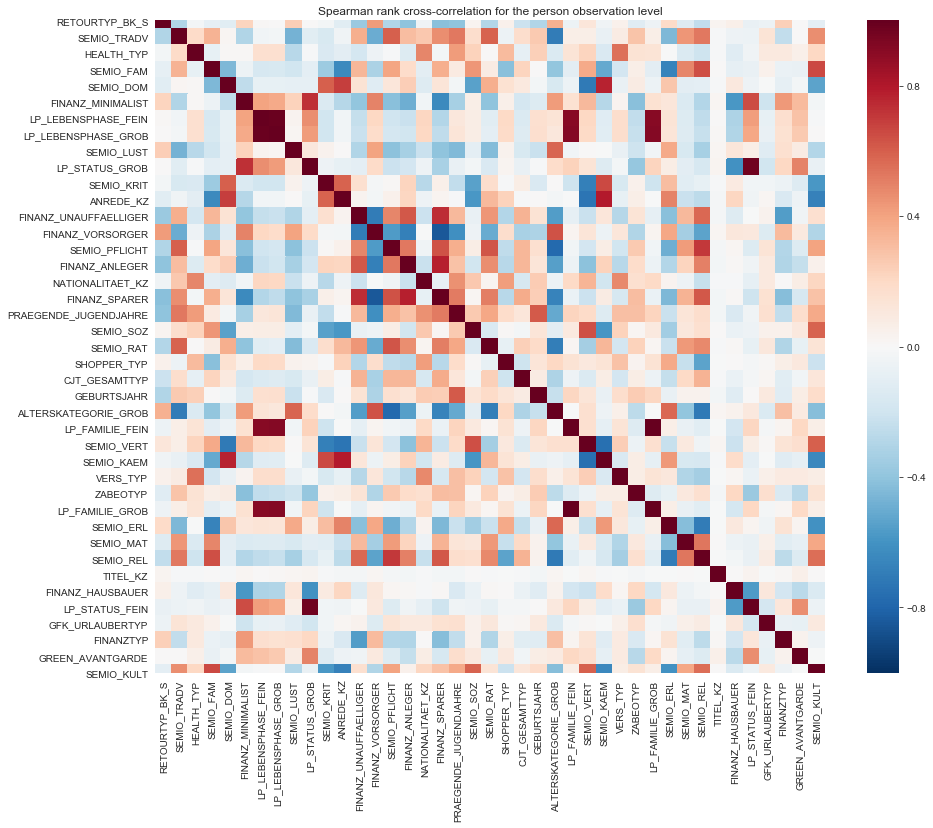

Wall time: 7.82 s


In [65]:
%%time
observation_level_correlations(azdias, azdias_info, 'Person', (15, 12), 'Spearman rank cross-correlation for the person observation level')

### Observation level: household

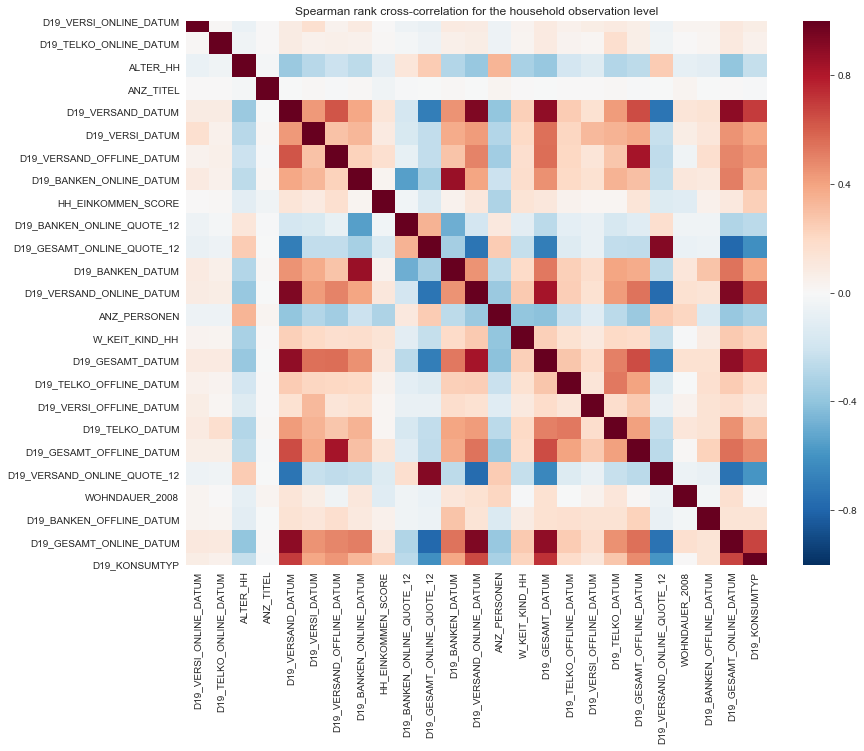

In [66]:
observation_level_correlations(azdias, azdias_info, 'Household', (13, 10), 'Spearman rank cross-correlation for the household observation level')

### Observation level: building

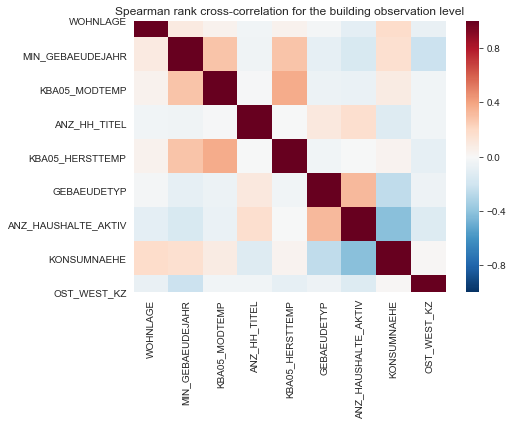

In [67]:
observation_level_correlations(azdias, azdias_info, 'Building', (7, 5), 'Spearman rank cross-correlation for the building observation level')

### Observation level: community

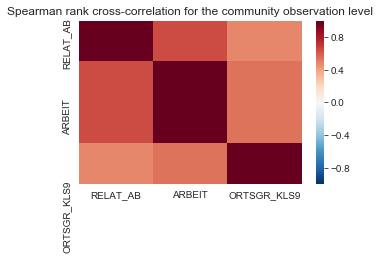

In [68]:
observation_level_correlations(azdias, azdias_info, 'Community', (5, 3), 'Spearman rank cross-correlation for the community observation level')

### Observation level: 125m x 125m grid

In [69]:
observation_level_correlations(azdias, azdias_info, '125m x 125m Grid', (25, 23), 'Spearman rank cross-correlation for the grid observation level')

'No features found in the data.'

### Observation level: micro-cell

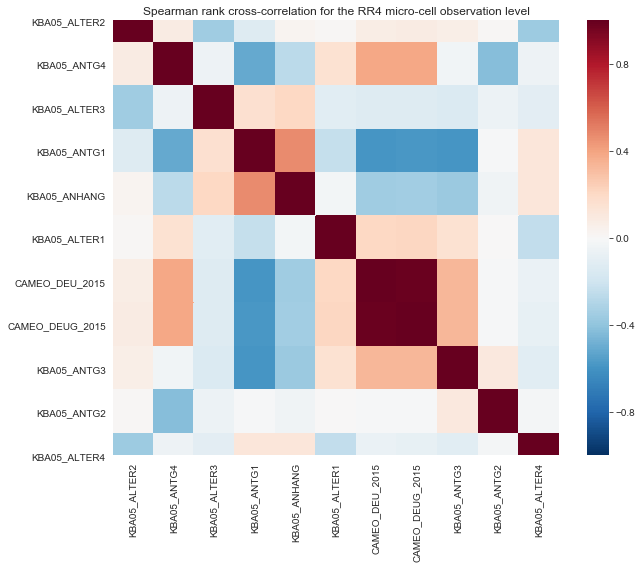

In [70]:
observation_level_correlations(azdias, azdias_info, 'Microcell (RR4_ID)', (10, 8), 'Spearman rank cross-correlation for the RR4 micro-cell observation level')

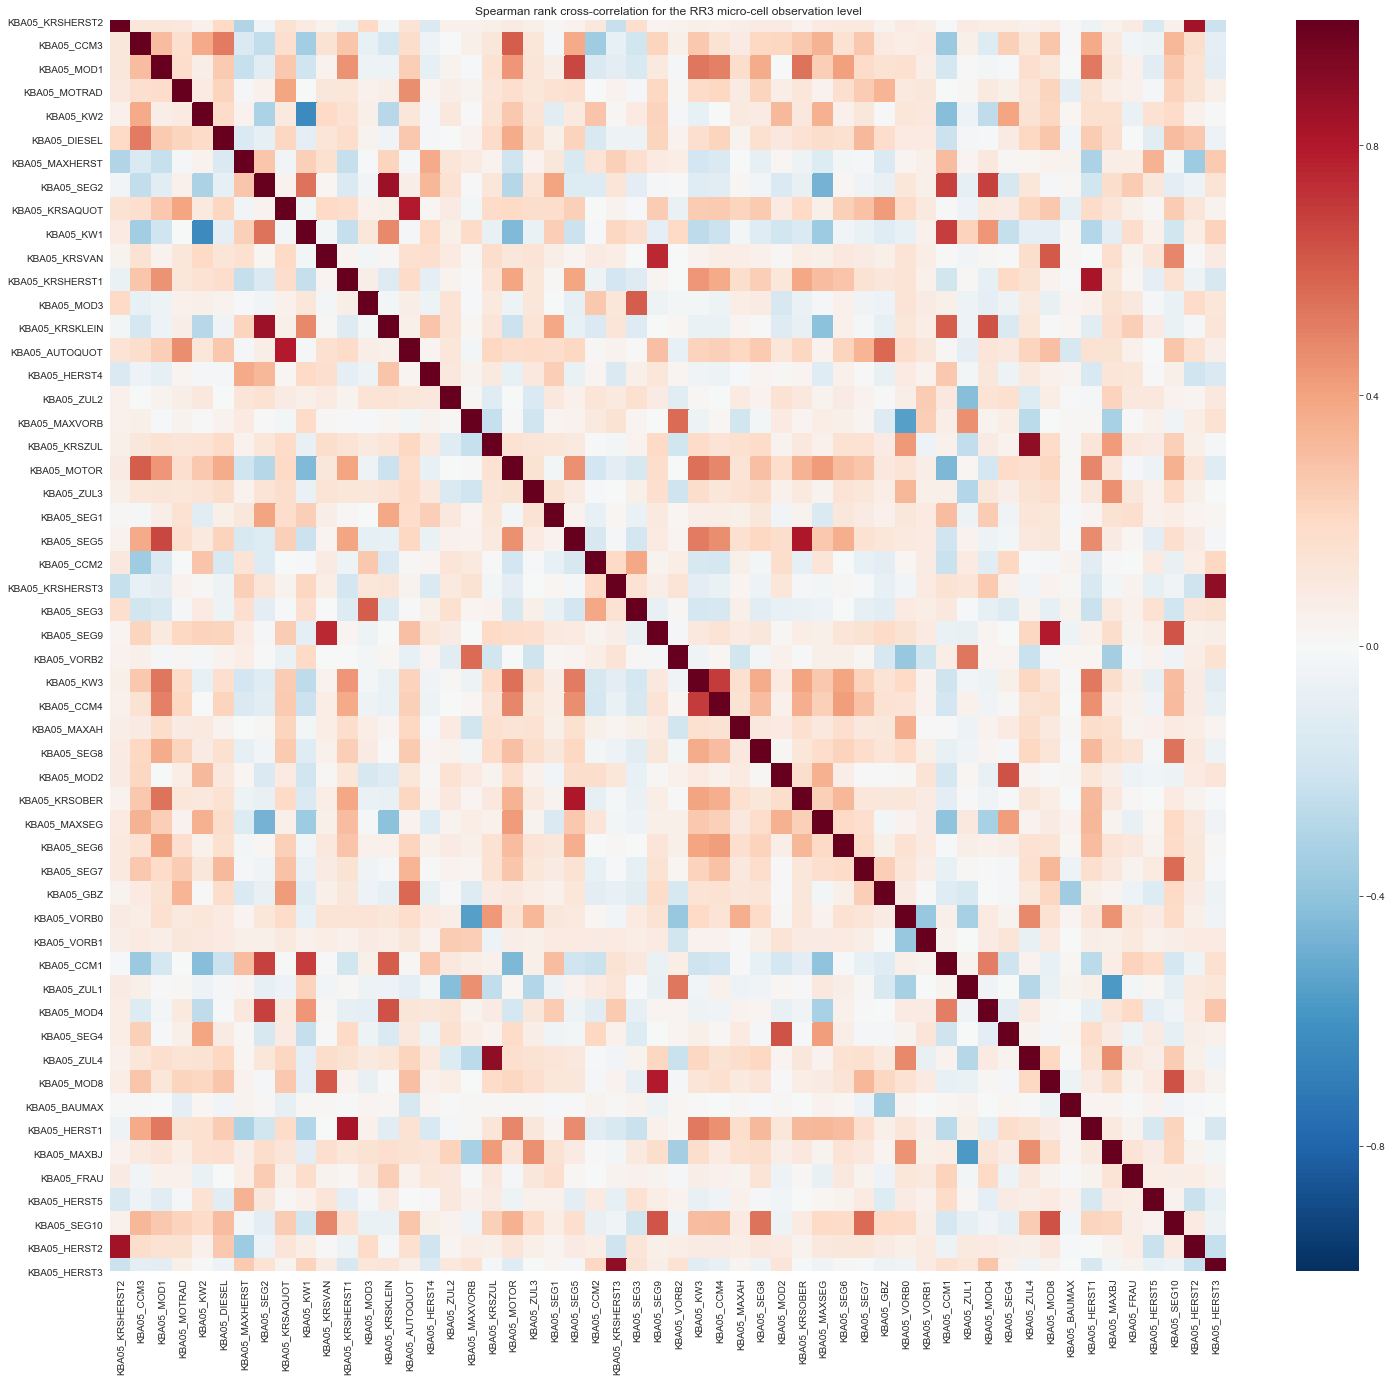

In [71]:
observation_level_correlations(azdias, azdias_info, 'Microcell (RR3_ID)', (25, 23), 'Spearman rank cross-correlation for the RR3 micro-cell observation level')

### Observation level: PLZ8

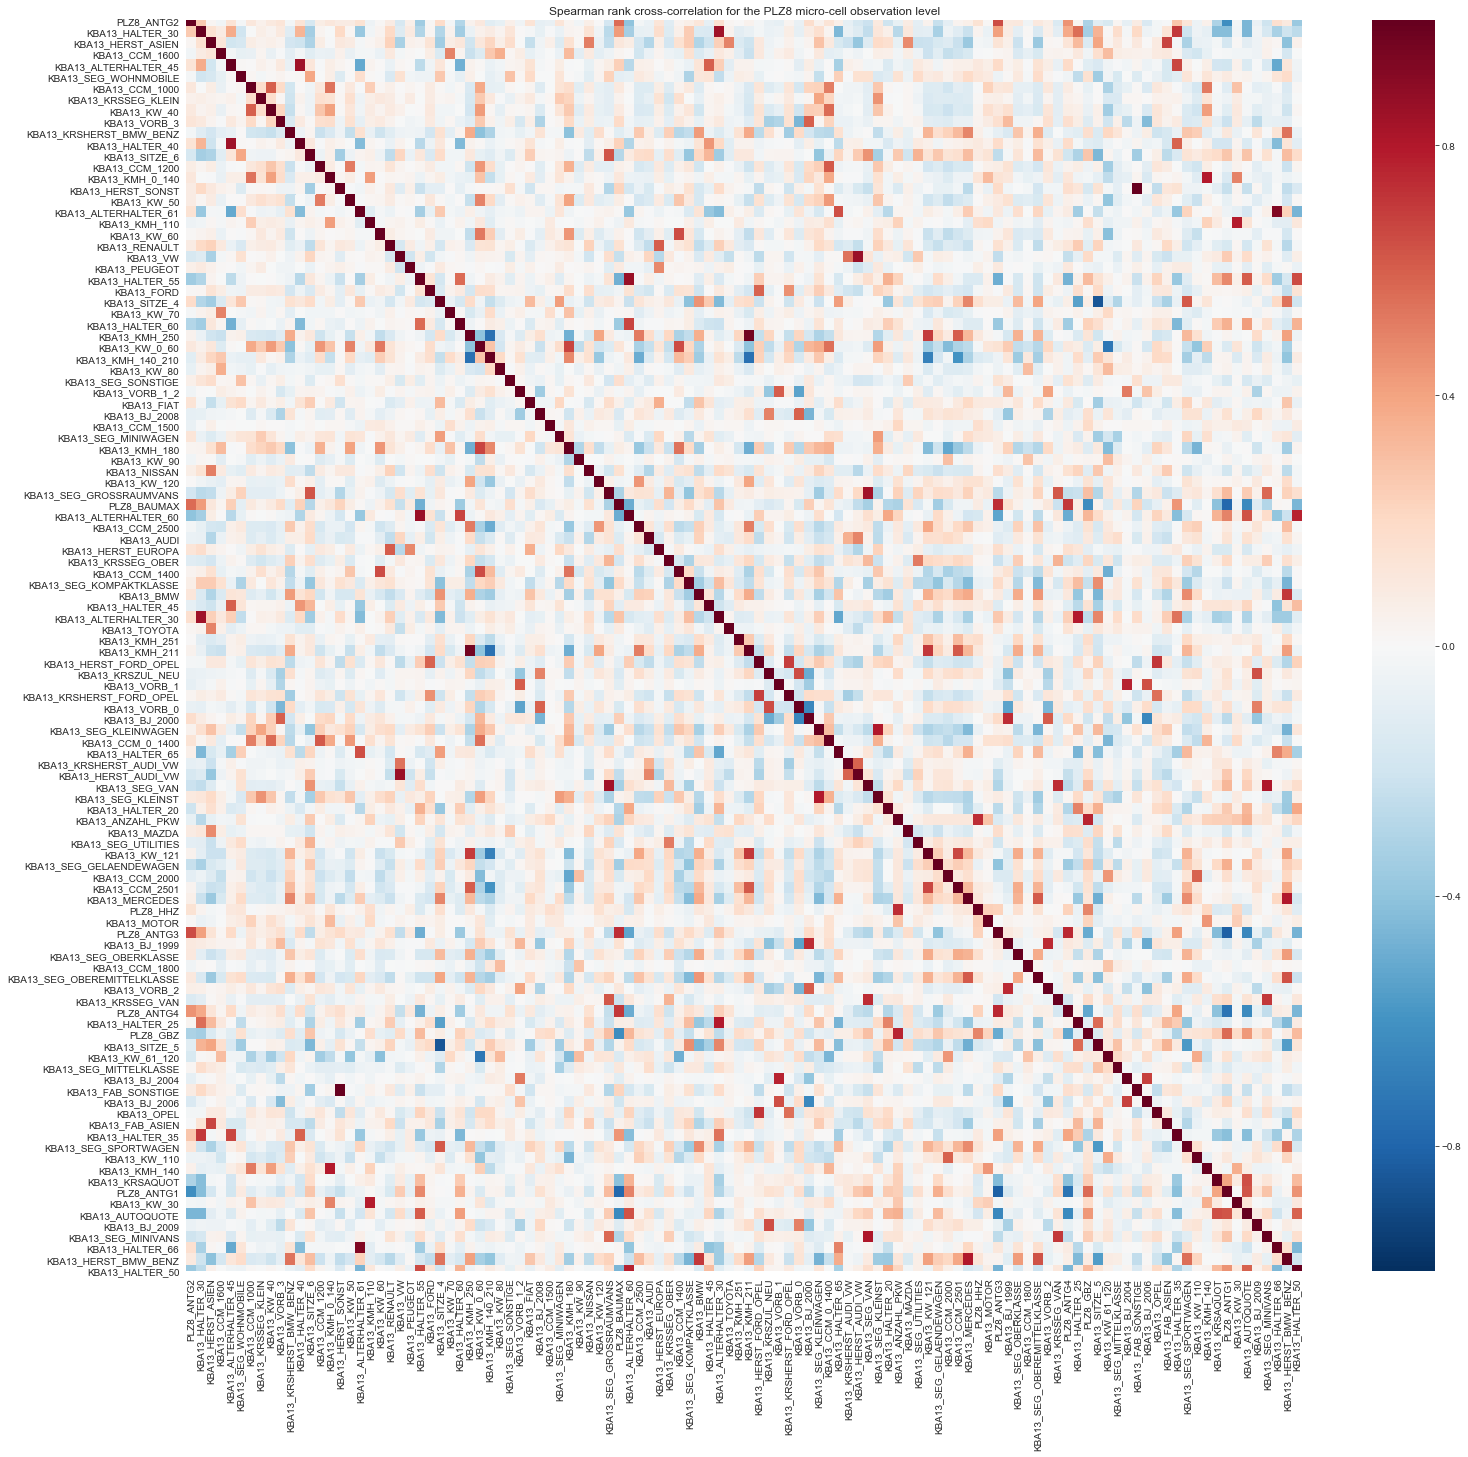

In [72]:
observation_level_correlations(azdias, azdias_info, 'PLZ8', (25, 23), 'Spearman rank cross-correlation for the PLZ8 micro-cell observation level')

### Observation level: RR1_ID

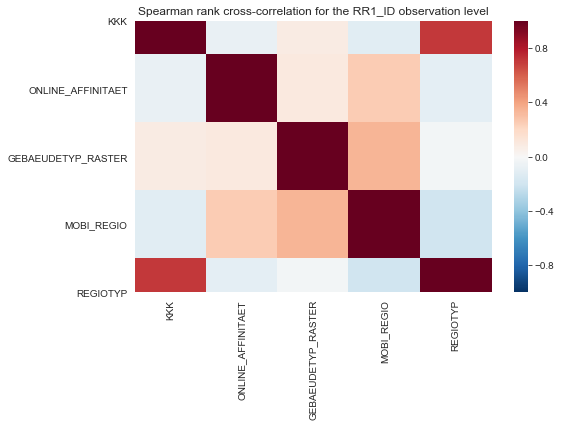

In [73]:
observation_level_correlations(azdias, azdias_info, 'RR1_ID', (8, 5), 'Spearman rank cross-correlation for the RR1_ID observation level')

### Observation level: postcode

In [74]:
observation_level_correlations(azdias, azdias_info, 'Postcode', (8, 5), 'Spearman rank cross-correlation for the postcode observation level')

'No features found in the data.'

# 3. Preprocessing

Since we want to perform a dataset exploration on the data we are actually going to use for unsupervised/supervised learning, let us first check whether major preprocessing steps are necessary (e.g. columns or rows with too much missing data, undocumented columns etc).

In [9]:
azdias_temp_df = azdias.copy()

## 3.1. Missing data

Since many missing values were already coded with a specific value, let us evaluate the real distribution of missing values by replacing these specific values with NA (np.nan).

In [10]:
# Extracting the attribute value rows where the meaning contains the word 'unknown'
na_codes = azdias_values.loc[azdias_values.Meaning.str.contains('unknown') == True, ['Attribute', 'Value']]

# Parsing the code values where multiple values are given and converting them to a list
na_codes.loc[:, 'Value'] = na_codes['Value'].apply(lambda x: [int(i) for i in str(x).split(',')]
                                                                if str(x).find(',') != -1 else [x])

# Creating a dictionary where the keys are the attribute names, and the values
#  are lists of codes corresponding to NA
na_dict = na_codes.set_index('Attribute')['Value'].to_dict()

# Printing the first 5 columns-NA code combinations
list(na_dict.items())[0:5]  

[('AGER_TYP', [-1]),
 ('ALTERSKATEGORIE_GROB', [-1, 0]),
 ('ALTER_HH', [0]),
 ('ANREDE_KZ', [-1, 0]),
 ('BALLRAUM', [-1])]

In [11]:
for col, nacode in na_dict.items():
    if col in azdias_temp_df.columns:
        azdias_temp_df.loc[azdias_temp_df[col].isin(nacode), col] = np.nan

In [12]:
pickle.dump(na_dict, open('./data/AzdiasNACodes.pkl', 'wb'))

Let us create a function in order to have reproducible preprocessing later on. This function maps every missing/unknown code to np.nan

In [13]:
def recode_NAs(df, na_codes):
    for col, nacode in na_codes.items():
        if col in df.columns:
            df.loc[df[col].isin(nacode), col] = np.nan
    
    return df

### 3.1.1. Missing data per columns

In [14]:
# Number of missing values per columns:
na_per_col = azdias_temp_df.isna().sum(axis=0)
print("Columns with at least one missing value:\n{}".format(na_per_col[na_per_col>0].sort_values(ascending=False)))

Columns with at least one missing value:
ALTER_KIND4                    890016
TITEL_KZ                       889061
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
AGER_TYP                       677503
EXTSEL992                      654153
KK_KUNDENTYP                   584612
KBA05_BAUMAX                   476524
ALTER_HH                       310267
ALTERSKATEGORIE_FEIN           262947
D19_LOTTO                      257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
D19_SOZIALES                   257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_KONSUMTYP                  257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_LETZTER_KAUF_BRANCHE       257113
REGIOTYP                       158064
KKK                            158064
KBA05_AUTOQUOT                 148115
KBA05_KRSVAN                   148110
KBA05_KRSOBER                  148110
KBA05_MOD

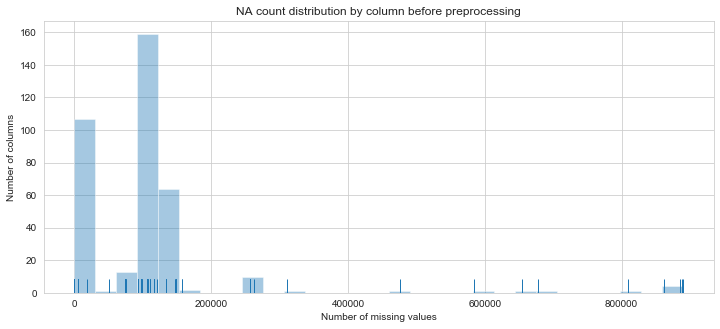

In [15]:
# Plot the NA count distribution by columns
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")
na_dist = sns.distplot(na_per_col, kde=False, rug=True)
na_dist.set(xlabel='Number of missing values',
            ylabel='Number of columns',
            title='NA count distribution by column before preprocessing');

In [16]:
# Dropping columns which have a certain number of missing values
na_limit_col = 300000
azdias_temp_df.drop(na_per_col[na_per_col > na_limit_col].index.values,
                    axis=1,
                    inplace=True)

# The dataframe shape after dropping outlier columns
print(azdias_temp_df.shape)

(891221, 356)


Since we want to use the same columns later on, and also for all the different datasets, let us save a pickle file with all the columns that we are dropping here.

In [17]:
pickle.dump(na_per_col[na_per_col > na_limit_col].index.values, open('./data/AzdiasDroppedColumns1.pkl', 'wb'))

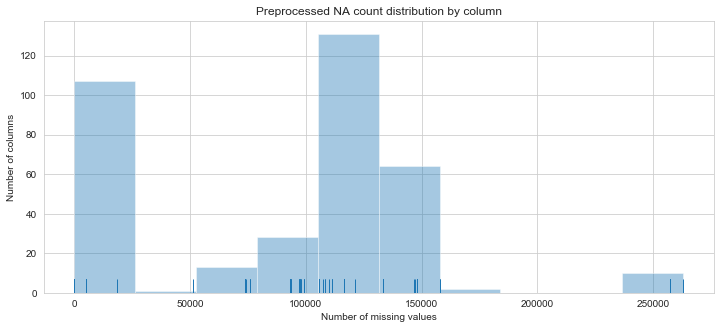

In [18]:
# Plot the NA distribution after removing the outlier columns
plt.figure(figsize=(12, 5))
na_dist = sns.distplot(na_per_col[na_per_col <= na_limit_col], kde=False, rug=True)
na_dist.set(xlabel='Number of missing values',
            ylabel='Number of columns',
            title='Preprocessed NA count distribution by column');

> **While this preprocessing step did not remove all missing data, the columns now have at least roughly three quarters of data available.**

### 3.1.2. Missing data per rows

In [19]:
na_per_row = azdias_temp_df.isna().sum(axis=1)
print("Rows with at least one missing value:\n{}".format(na_per_row[na_per_row>0].sort_values(ascending=False)))

Rows with at least one missing value:
537799    254
826869    254
350182    253
373501    253
55664     253
         ... 
98178       1
510047      1
618557      1
461535      1
451064      1
Length: 467008, dtype: int64


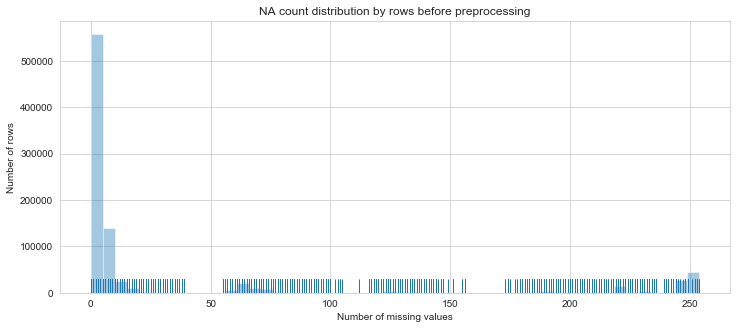

In [20]:
# Plot the NA count distribution by rows
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))
na_dist = sns.distplot(na_per_row, kde=False, rug=True)
na_dist.set(xlabel='Number of missing values',
            ylabel='Number of rows',
            title='NA count distribution by rows before preprocessing');

In [21]:
# Dropping rows which have a certain number of missing values
na_limit_row = 100
azdias_temp_df.drop(na_per_row[na_per_row > na_limit_row].index.values,
                    axis=0,
                    inplace=True)

# The dataframe shape after dropping the outlier columns
print(azdias_temp_df.shape)

(785414, 356)


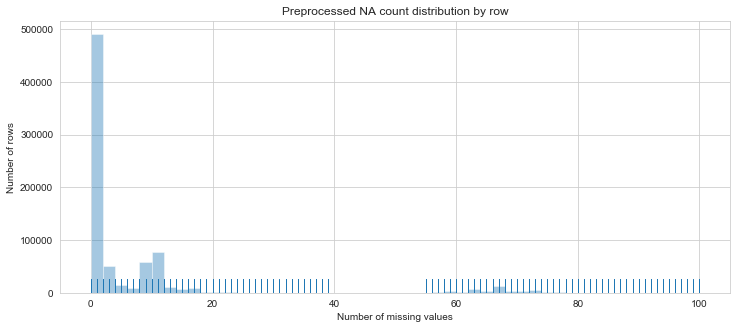

In [22]:
# Plot the NA distribution after removing the outlier rows
plt.figure(figsize=(12, 5))
na_dist = sns.distplot(na_per_row[na_per_row <= na_limit_row], kde=False, rug=True)
na_dist.set(xlabel='Number of missing values',
            ylabel='Number of rows',
            title='Preprocessed NA count distribution by row');

> **After this preprocessing step, the vast majority of the rows now have no missing data.**

Let us create a preprocessing function that removes all rows which have more than a number of missing fields (100, by default). We can use this function to preprocess further datasets.

In [23]:
def drop_min_na_rows(df, na_limit=100):
    na_per_row = df.isna().sum(axis=1)
    df.drop(na_per_row[na_per_row > na_limit_row].index.values,
            axis=0,
            inplace=True)   
    
    return df

Now that we have explored our preliminary dataset, let us proceed with the following preprocessing steps: encoding string variables, one-hot encoding for categorical features, and filling in the missing values. Since we are operating with multiple datasets, let us define a function for each of these steps. Additionally, given that the dataset has multiple types of variables, let us define some lists that will help ensure adequate preprocessing.

## 3.2. Redundant columns

Based on the "DIAS Information Levels - Attributes 2017.xlsx" file, there are some columns which are correlated. Specifically, they represent different granularity levels of observation. For instance, there are columns including the word "GROB" (German for coarse) which indicate more general levels of observation. If we need to dummy-encode them, these would generate a lower dimensionality than their "FEIN" (fine) equivalent. As a result, we will drop all colums containing the word "FEIN".<br><br>
We will additionally drop the column CAMEO_DEU_2015, since, based on the description, it is the "FEIN" equivalent of CAMEO_DEUG_2015, along with the column CAMEO_INTL_2015, which offers the same information.<br><br>
The GEBURTSJAHR (birth year) column will also be dropped since more than 250,000 values are equal to 0. We will rely on the age category column.<br><br>
We will also drop the EINGEFUEGT_AM column, since, based on the German translation ("added on"), it represents the data collection date for the respective line. Keeping it would only produce overfitting. The same reasoning will be applied to the LNR (line number) column.<br>

In [24]:
# List of columns to drop
col_drop1 = [col for col in azdias_temp_df.columns if "FEIN" in col] + \
            ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'EINGEFUEGT_AM', 'GEBURTSJAHR', 'KBA05_MAXHERST', 'LNR']
#nondocumented_cols = [col for col in azdias_temp_df.columns if col not in set(azdias_info.Attribute.unique()).union(azdias_values.Attribute.unique())]
azdias_temp_df.drop(col_drop1,
                    axis=1,
                    inplace=True)

Since we want to use the same columns later on, and also for all the different datasets, let us save a pickle file with all the columns that we are dropping here.

In [25]:
pickle.dump(col_drop1, open('./data/AzdiasDroppedColumns2.pkl', 'wb'))

In [54]:
def drop_columns(df, cols):
    if len(cols) != 0:
        df = df.drop(cols, axis=1, errors='ignore')
    
    return df

## 3.3. Definition of feature types

Based on the information in the documentation files in Excel, let us use the following lists to define the main types of features:
* **categorical features**: while most of these are encoded as a numeric type, there is no inherent order in their distinct values
* **numeric features**: these columns are explicitly indicated as "numeric value" in the DIAS Attributes - Values 2017
* **ordinal features**: by far the most frequent type (given the survey nature of the dataset), they will be declared as the remaining features after eliminating both numeric and categorical features

In [28]:
dict_feature_types = {}
dict_feature_types['dummy'] = ['CAMEO_DEUG_2015', 'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 'CJT_GESAMTTYP',
                               'HEALTH_TYP', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB',
                               'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
                               'SHOPPER_TYP']
dict_feature_types['encoding'] = [c for c in azdias_temp_df.columns if azdias_temp_df.dtypes[c] == 'object']
dict_feature_types['numeric'] = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'ARBEIT',
                                 'KBA13_ANZAHL_PKW', 'MIN_GEBAEUDEJAHR']
dict_feature_types['ordinal'] = [col for col in azdias_temp_df.columns if col not in dict_feature_types['dummy']+dict_feature_types['encoding']+dict_feature_types['numeric']]

In [29]:
pickle.dump(dict_feature_types, open('./data/AzdiasFeatureTypeDictionary.pkl', 'wb'))

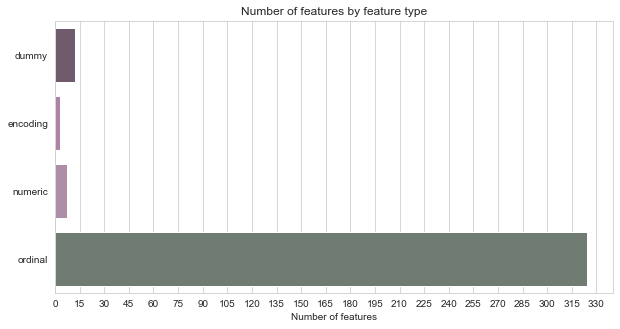

In [97]:
plt.figure(figsize=(10, 5))
sns.barplot(x=[len(dict_feature_types[key]) for key, value in dict_feature_types.items()],
            y=[key for key, value in dict_feature_types.items()],
            palette='cubehelix_d')
plt.title('Number of features by feature type')
plt.xlabel('Number of features')
plt.xticks(np.arange(0, 331, 15))
plt.show()

## 3.4. String feature encoding

In [30]:
def categorical_encoding(df, cols):
    if len(cols) != 0:
        try:
            encoding_dict = pickle.load(open('./data/AzdiasEncodingDictionary.pkl', 'rb'))
        except:
            encoding_dict = {}
        
        if encoding_dict == {}:
            for c in cols:
                categ_encoder = LabelEncoder()
                df.loc[:, c] = categ_encoder.fit_transform(df.loc[:, c].fillna('NA').astype('str'))
                encoding_dict[c] = categ_encoder
            pickle.dump(encoding_dict, open('./data/AzdiasEncodingDictionary.pkl', 'wb'))
            
        else:
            for c in cols:
                df.loc[:, c] = encoding_dict[c].transform(df.loc[:, c].fillna(stats.mode(df.loc[:, c]).mode[0]))
    
    return df

In [31]:
azdias_temp_df = categorical_encoding(azdias_temp_df, dict_feature_types['encoding'])

## 3.5. One-hot encoding

In [36]:
def one_hot_encoding(df, cols):
    if len(cols) != 0:
        df = pd.get_dummies(df, columns=cols, dummy_na=True)
        
    return df 

In [37]:
dummy_features = [c for c in azdias_temp_df.columns
                  if c in dict_feature_types['dummy'] or (c in dict_feature_types['encoding'] and azdias_temp_df[c].nunique() > 2)]

In [38]:
azdias_temp_df = one_hot_encoding(azdias_temp_df, dummy_features)

## 3.6. Imputing the missing data

In [39]:
def fill_missing_data(df, ordinal_cols, numeric_cols, numeric_imputer_strategy='median'):
    # Ordinal features will be filled in with -1 where data is missing
    if len(ordinal_cols) != 0:
        df.loc[:, ordinal_cols] = df.loc[:, ordinal_cols].fillna(-1)
    
    # NAs in numeric features will be filled in with the column median
    if len(numeric_cols) != 0:
        numeric_imputer = SimpleImputer(missing_values=np.nan, strategy=numeric_imputer_strategy)
        df.loc[:, numeric_cols] = numeric_imputer.fit_transform(df.loc[:, numeric_cols])
    
    # The remaining dummy columns will be filled in with 0 where data is missing
    df.fillna(0, inplace=True)
    
    return df

In [40]:
azdias_temp_df = fill_missing_data(azdias_temp_df, dict_feature_types['ordinal'], dict_feature_types['numeric'])

## 3.7. Normalization

In order to perform PCA, we shall normalize the ordinal and numeric variables, such that they have the mean equal to 0 and the standard deviation equal to 1.

In [41]:
def normalization(df, cols):
    if len(cols) != 0:
        scaler = MinMaxScaler()
        df.loc[:, cols] = scaler.fit_transform(df.loc[:, cols])
            
    return df, scaler

In [42]:
azdias_temp_df, minmaxscaler = normalization(azdias_temp_df, dict_feature_types['ordinal']+dict_feature_types['numeric'])

Since we may need to reverse transform this scaling, let us save the scaler.

In [43]:
pickle.dump(minmaxscaler, open('./data/PopulationMinMaxScaler.pkl', 'wb'))

Let's see the top 5 rows to make sure our preprocessing went well.

In [44]:
print('Preprocessed dataset shape:', azdias_temp_df.shape)
azdias_temp_df.head()

Preprocessed dataset shape: (785414, 479)


,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FIRMENDICHTE,GEBAEUDETYP_RASTER,GEMEINDETYP,GREEN_AVANTGARDE,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,...,KONSUMNAEHE,KONSUMZELLE,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,CAMEO_DEUG_2015_0.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_10.0,CAMEO_DEUG_2015_11.0,CAMEO_DEUG_2015_12.0,CAMEO_DEUG_2015_13.0,CAMEO_DEUG_2015_14.0,CAMEO_DEUG_2015_15.0,CAMEO_DEUG_2015_16.0,CAMEO_DEUG_2015_17.0,CAMEO_DEUG_2015_19.0,CAMEO_

In [45]:
pickle.dump(list(azdias_temp_df.columns), open('./data/AzdiasFinalFeatures.pkl', 'wb'))

In [46]:
def add_missing_columns(df):
    try:
        cols = list(set(pickle.load(open('./data/AzdiasFinalFeatures.pkl', 'rb'))) - set(df.columns))
        for c in cols:
            df.insert(loc=len(df.columns), column=c, value=0, allow_duplicates=True)
        return df
    except:
        return df

## 3.9. Creating a preprocessing function

In [48]:
def arvato_preprocessing(df, na_codes, drop_cols, row_na_limit, encoding_cols, dummy_cols, ordinal_cols, numeric_cols, imputer_strategy):
    arv = recode_NAs(df.copy(), na_codes)
    arv = drop_min_na_rows(arv, na_limit=row_na_limit)
    arv = categorical_encoding(arv, cols=encoding_cols)
    arv = one_hot_encoding(arv, cols=dummy_cols)
    arv = fill_missing_data(arv,
                            ordinal_cols=ordinal_cols,
                            numeric_cols=numeric_cols,
                            numeric_imputer_strategy=imputer_strategy)
    arv, _ = normalization(arv, ordinal_cols+numeric_cols)
    arv = drop_columns(arv, cols=drop_cols)
    arv = add_missing_columns(arv)
    
    return arv

In [49]:
try:
    na_codes = pickle.load(open('./data/AzdiasNACodes.pkl', 'rb'))
    print('Successfully loaded NA code dictionary.')
except:
    print('NA code di ctionary not found.')

Successfully loaded NA code dictionary.


In [50]:
try:
    dict_feature_types = pickle.load(open('./data/AzdiasFeatureTypeDictionary.pkl', 'rb'))
    print('Successfully loaded feature type dictionary.')
except:
    print('Feature type dictionary not found. Initialize feature types.')

Successfully loaded feature type dictionary.


In [51]:
try:
    drop_cols = list(pickle.load(open('./data/AzdiasDroppedColumns1.pkl', 'rb'))) + \
                list(pickle.load(open('./data/AzdiasDroppedColumns2.pkl', 'rb'))) 
    print('Successfully loaded list of features to drop.')
except:
    print('No list of columns to drop was found.')

Successfully loaded list of features to drop.


## 3.10. Preprocessing the remaining dataset

In [56]:
azdias_customers_final = arvato_preprocessing(customers,
                                              na_codes=na_codes,
                                              drop_cols=drop_cols,
                                              row_na_limit=100,
                                              encoding_cols=dict_feature_types['encoding'],
                                              dummy_cols=dummy_features,
                                              ordinal_cols=dict_feature_types['ordinal'],
                                              numeric_cols=dict_feature_types['numeric'],
                                              imputer_strategy='median')

In [61]:
train = arvato_preprocessing(mailout_train,
                             na_codes=na_codes,
                             drop_cols=drop_cols,
                             row_na_limit=100,
                             encoding_cols=dict_feature_types['encoding'],
                             dummy_cols=dummy_features,
                             ordinal_cols=dict_feature_types['ordinal'],
                             numeric_cols=dict_feature_types['numeric'],
                             imputer_strategy='median')

In [62]:
test = arvato_preprocessing(mailout_test,
                            na_codes=na_codes,
                            drop_cols=drop_cols,
                            row_na_limit=100,
                            encoding_cols=dict_feature_types['encoding'],
                            dummy_cols=dummy_features,
                            ordinal_cols=dict_feature_types['ordinal'],
                            numeric_cols=dict_feature_types['numeric'],
                            imputer_strategy='median')

## 3.11. Saving the final datasets

In [52]:
azdias_population_final = azdias_temp_df.copy()

These are the datasets that we will use for the unsupervised learning analysis.

In [311]:
azdias_population_final.to_csv('./data/AzdiasPopulationPreprocessed.csv', index=False)
azdias_customers_final.to_csv('./data/AzdiasCustomersPreprocessed.csv', index=False)

These are the datasets that we will use for the supervised learning analysis.

In [63]:
train.to_csv('./data/PreprocessedMailoutTrain.csv', index=False)
test.to_csv('./data/PreprocessedMailoutTest.csv', index=False)